In [1]:
import seaborn as sns
sns.set()

# Image Classification with TensorFlow

In this project, I build a series of models to classify a series of images into one of ten classes. For expediency, these images are pretty small ($32\times32\times3$).  This can make classification a bit tricky&mdash;human performance is only about 94%. 

I will be use both a training set and a validation set.  Ground truth values are for the training set. I train my models on this set, and then make predictions for each of the validation images. 

## Downloading the data

I will be using the `CIFAR-10` data set.  It consists of 60,000 images, each $32\times32$ color pixels, each belonging to one of ten classes.  The following cell will download the data, in NumPy's `.npy` format.

In [3]:
!aws s3 sync s3://data/cifar10/ .

I can load in the data like so:

In [4]:
import numpy as np
import gzip

train_images = np.load(gzip.open('train_images.npy.gz', 'rb'))
train_labels = np.load(gzip.open('train_labels.npy.gz', 'rb'))
validation_images = np.load(gzip.open('validation_images.npy.gz', 'rb'))

The images are stored as four-dimensional arrays.  The first index indicates the image number, the second and third the $x$ and $y$ positions, and the fourth index the color channel.  Each pixel color is a floating point number between 0 and 1.  This convention allows us to view the images with matplotlib:

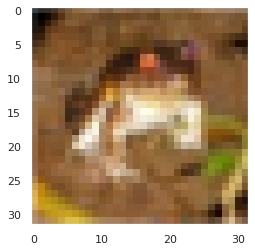

In [5]:
import matplotlib.pyplot
matplotlib.pyplot.rcParams["axes.grid"] = False  #  Remove the grid lines from the image.
matplotlib.pyplot.imshow(train_images[0])

In [6]:
len(train_images)

50000

The classes have already been numbered 0-9 for us; those numbers are stored in the vector `train_labels`.

In [7]:
train_labels[0]

6

In [8]:
len(train_labels)

50000

The human-readable names associated with this classes are

In [9]:
label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

In [10]:
label_names[train_labels[0]]

'frog'

So I can see that the image above is a frog.  

## Perceptual Delta

Since I already have a number of labeled images, a simple approach would be to measure the difference between two images, and choose the label corresponding to nearby images.  To do this, I need to develop a metric to determine the distance between two images.  I'll make the simplifying (and completely wrong) assumption that this is just the average difference between the colors of the corresponding pixels in the two images.

While I could just take RMS difference of the red, green, and blue pixels, I'll be slightly more sophisticated and look at human vision for a metric.  

It turns out that modeling human perception is [extraordinarily complicated](https://en.wikipedia.org/wiki/Color_difference#CIEDE2000).  I'm going to use a [simplified model](https://www.compuphase.com/cmetric.htm):

$$\Delta C \equiv \sqrt{2 \Delta R^2 + 4 \Delta G^2 + 3 \Delta B^2 + \bar R\left(\Delta R^2 - \Delta B^2 \right)} $$
where $(R_1, G_1, B_1)$ and $(R_2, G_2, B_2)$ are the RGB components of the two colors and
$$\begin{align}
\Delta R &= R_1 - R_2 \\
\Delta G &= G_1 - G_2 \\
\Delta B &= B_1 - B_2 \\
\bar R &= \textstyle\frac{1}{2}\left(R_1 + R_2\right)
\end{align}$$

This accounts for the fact that our eyes are most sensitive to green and least sensitive to red, and that perception is not constant with hue.

I'll build a graph that takes in a series of images, as well as a base image, and returns a result containing the $\Delta C$ value (for each pixel) between the base image and each image in the series.  

(Note that `images` will be a stack of images, while `base` is a single image. Since the function is decorated with `tf.function` the computations within the function will be recorded in a computation graph and the output from this function will be a tensor.)

In [11]:
(train_images[1][:,:,0]**2)

array([[0.3647213 , 0.24415225, 0.16955018, ..., 0.12735103, 0.11640139,
        0.09597848],
       [0.30142257, 0.3233372 , 0.24029219, ..., 0.14173011, 0.09118032,
        0.07752404],
       [0.30142257, 0.2971319 , 0.20338331, ..., 0.09597848, 0.07111112,
        0.06903499],
       ...,
       [0.47097272, 0.37425607, 0.3647213 , ..., 0.02712803, 0.05722414,
        0.13301039],
       [0.41868514, 0.37425607, 0.38878897, ..., 0.16315264, 0.23266436,
        0.2639139 ],
       [0.40859672, 0.3839139 , 0.40859672, ..., 0.31447908, 0.31447908,
        0.31447908]], dtype=float32)

In [12]:
train_images[1][:,:,0]

array([[0.6039216 , 0.49411765, 0.4117647 , ..., 0.35686275, 0.34117648,
        0.30980393],
       [0.54901963, 0.5686275 , 0.49019608, ..., 0.3764706 , 0.3019608 ,
        0.2784314 ],
       [0.54901963, 0.54509807, 0.4509804 , ..., 0.30980393, 0.26666668,
        0.2627451 ],
       ...,
       [0.6862745 , 0.6117647 , 0.6039216 , ..., 0.16470589, 0.23921569,
        0.3647059 ],
       [0.64705884, 0.6117647 , 0.62352943, ..., 0.40392157, 0.48235294,
        0.5137255 ],
       [0.6392157 , 0.61960787, 0.6392157 , ..., 0.56078434, 0.56078434,
        0.56078434]], dtype=float32)

In [13]:
import tensorflow as tf

@tf.function
def delta_func(images, base):
    return  tf.sqrt(2*(images[:,:,0]-base[:,:,0])**2+\
                    4*(images[:,:,1]-base[:,:,1])**2+\
                    3*(images[:,:,2]-base[:,:,2])**2+\
                    (images[:,:,0]+base[:,:,0])/2*((images[:,:,0]-base[:,:,0])**2-(images[:,:,2]-base[:,:,2])**2))

As stated, for two images, $I_1$ and $I_2$, I define the distance between $I_1$ and $I_2$ as the average $\Delta C$ value over the whole image, that is:

$$d(I_1, I_2) = \frac{1}{N}\sum_{p_j} \Delta C(p_j)$$
where the sum is over all pixels $p_j$, $\Delta C(p_2)$ is the $\Delta C$ value for the pixel $p_j$, and $N$ is the total number of pixels in each image ($N= 32\times 32$ in our case).

Using `delta_func` compute the distance between the first validation image and all of the training images.


In [14]:
mydiff = delta_func(train_images[0],validation_images[0])

In [15]:
full_deltas = {}
for i in range(50000):
    delta_image = delta_func(train_images[i],validation_images[0])
    full_deltas[i]=delta_image.numpy().mean()

In [16]:
deltas = sorted(full_deltas.items(),key=lambda item :item[1])

In [17]:
indices = [delta[0] for delta in deltas[:100]]

From these, find the 100 closest images from the training set to this first validation image.  

## Softmax model

I could use this delta function to measure distances from images with known classes, but that's not really the Deep Learning Way (TM). Instead, I'll let neural networks figure out how to connect pixel values to classes.

I'll start with something that barely qualifies as a neural network: a softmax classifier. This has no hidden layers; instead a single dense layer takes $32\times32\times3$ inputs and produces 10 outputs, one for each class. It should use a softmax activation and a `CategoricalCrossentropy` loss function.

I'll build such a model and train it on the training data. Then, will use this model to make a prediction on each of the 10,000 validation images.  

Looking only at the smallest distance is throwing some information away. I would expect some classes to have more variation that others. Also, I would expect correlation between the classes&mdash; a small distance to *cat* is probably more likely for *dog* than for *airplane*.

Instead of a trying to work out these effects heuristically, let the computer do it. I'll build a softmax model that takes as input features the distances from all ten typical images and makes a class prediction from those. Again, will use this to predict the class for each of the validation images. 

In [19]:
import seaborn as sns
sns.set()

import numpy as np
import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt

# from pylib.draw_nn import draw_neural_net_fig

In [20]:
model = keras.models.Sequential()

In [21]:
from tensorflow.keras.utils import to_categorical as one_hot

y_train_hot = one_hot(train_labels)
N_PIXELS = train_images.shape[1]*train_images.shape[2]*train_images.shape[3]

In [22]:
# model.add(keras.layers.Input(shape = (32,32,3)))
# model.add(flatten())
model.add(keras.layers.Flatten(input_shape=(32,32,3)))
model.add(
    keras.layers.Dense(
        10,
        activation='softmax',
        use_bias=True,  # The default
        kernel_initializer=keras.initializers.TruncatedNormal(stddev=N_PIXELS**-0.5)
    )
)

In [23]:
model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.SGD(lr=0.01),
              metrics=['accuracy'])

In [24]:
history = model.fit(train_images, y_train_hot,
                    epochs=25,
                    batch_size=300)

Epoch 1/25
167/167 [==============================] - 1s 5ms/step - loss: 2.0832 - accuracy: 0.2496
Epoch 2/25
167/167 [==============================] - 1s 5ms/step - loss: 1.9344 - accuracy: 0.3271
Epoch 3/25
167/167 [==============================] - 1s 6ms/step - loss: 1.8841 - accuracy: 0.3481
Epoch 4/25
167/167 [==============================] - 1s 6ms/step - loss: 1.8572 - accuracy: 0.3583
Epoch 5/25
167/167 [==============================] - 1s 5ms/step - loss: 1.8386 - accuracy: 0.3659
Epoch 6/25
167/167 [==============================] - 1s 5ms/step - loss: 1.8255 - accuracy: 0.3708
Epoch 7/25
167/167 [==============================] - 1s 5ms/step - loss: 1.8143 - accuracy: 0.3744
Epoch 8/25
167/167 [==============================] - 1s 5ms/step - loss: 1.8055 - accuracy: 0.3775
Epoch 9/25
167/167 [==============================] - 1s 5ms/step - loss: 1.7977 - accuracy: 0.3811
Epoch 10/25
167/167 [==============================] - 1s 5ms/step - loss: 1.7908 - accuracy: 0.3837

In [25]:
predicted_classes = np.argmax(model.predict(validation_images),axis=1)

## Fully-connected model

Now, I'll add a hidden layer to this network. Will train this network on the pixel values, and once again use it to predict the most likely class for each of the validation images.

In [27]:
hidden_size = 1000
drop_rate = 0.5 

In [28]:
model2 = keras.models.Sequential()
model2.add(keras.layers.Flatten(input_shape=(32,32,3)))



In [29]:
model2.add(keras.layers.Dropout(drop_rate))

model2.add(
    keras.layers.Dense(
        hidden_size,
        activation='relu',
        use_bias=True,  # The default
        kernel_initializer=keras.initializers.TruncatedNormal(stddev=N_PIXELS**-0.5)
    )
)

In [30]:
model2.add(keras.layers.Dropout(drop_rate))

model2.add(
    keras.layers.Dense(
        10,
        activation='softmax',
        use_bias=True,  # The default
    )
)

In [31]:
model2.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.SGD(lr=0.01),
              metrics=['accuracy'])

In [32]:
history2 = model2.fit(train_images, y_train_hot,
                    epochs=25,
                    batch_size=300)

Epoch 1/25
167/167 [==============================] - 6s 33ms/step - loss: 2.2619 - accuracy: 0.1762
Epoch 2/25
167/167 [==============================] - 5s 33ms/step - loss: 2.0951 - accuracy: 0.2327
Epoch 3/25
167/167 [==============================] - 5s 33ms/step - loss: 2.0386 - accuracy: 0.2569
Epoch 4/25
167/167 [==============================] - 6s 33ms/step - loss: 2.0014 - accuracy: 0.2732
Epoch 5/25
167/167 [==============================] - 5s 33ms/step - loss: 1.9744 - accuracy: 0.2835
Epoch 6/25
167/167 [==============================] - 6s 33ms/step - loss: 1.9617 - accuracy: 0.2908
Epoch 7/25
167/167 [==============================] - 5s 32ms/step - loss: 1.9454 - accuracy: 0.2993
Epoch 8/25
167/167 [==============================] - 5s 33ms/step - loss: 1.9299 - accuracy: 0.3073
Epoch 9/25
167/167 [==============================] - 5s 33ms/step - loss: 1.9178 - accuracy: 0.3095
Epoch 10/25
167/167 [==============================] - 5s 33ms/step - loss: 1.9047 - accura

In [33]:
predicted_classes = np.argmax(model2.predict(validation_images),axis=1)

## Convolutional model

Convolutional neural networks have had a lot of success in image classification. I'll build a neural network with convolutional layers to improve the performance.

In [62]:
img_size = 28
img_size_flat = img_size * img_size
img_shape = (img_size, img_size)

n_classes = 10
n_channels = 1
filt_size = [5, 5] # 5x5 pixel filters

batch_size = 50
n_epochs = 5

hidden_size = 1000

In [63]:
model3 = keras.models.Sequential()

model3.add(keras.layers.Conv2D(16, filt_size, padding='same',
                              activation='relu'))

model3.add(keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2),
                                    padding='same'))

model3.add(keras.layers.Flatten())

model3.add(keras.layers.Dense(hidden_size, activation='relu'))

model3.add(
    keras.layers.Dense(
        10,
        activation='softmax',
        use_bias=True,  # The default
    )
)

In [64]:
model3.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])

In [65]:
history3 = model3.fit(train_images, y_train_hot,
                    epochs=25,
                    batch_size=300)

Epoch 1/25
167/167 [==============================] - 29s 176ms/step - loss: 1.8622 - accuracy: 0.3478
Epoch 2/25
167/167 [==============================] - 29s 174ms/step - loss: 1.3958 - accuracy: 0.5071
Epoch 3/25
167/167 [==============================] - 29s 174ms/step - loss: 1.2249 - accuracy: 0.5714
Epoch 4/25
167/167 [==============================] - 29s 174ms/step - loss: 1.1188 - accuracy: 0.6085
Epoch 5/25
167/167 [==============================] - 29s 173ms/step - loss: 1.0390 - accuracy: 0.6371
Epoch 6/25
167/167 [==============================] - 29s 173ms/step - loss: 0.9751 - accuracy: 0.6610
Epoch 7/25
167/167 [==============================] - 29s 174ms/step - loss: 0.9067 - accuracy: 0.6820
Epoch 8/25
167/167 [==============================] - 29s 174ms/step - loss: 0.8549 - accuracy: 0.7036
Epoch 9/25
167/167 [==============================] - 29s 173ms/step - loss: 0.8008 - accuracy: 0.7212
Epoch 10/25
167/167 [==============================] - 29s 174ms/step - l

In [66]:
predicted_classes = np.argmax(model3.predict(validation_images),axis=1)

## Transfer learning

In transfer learning, I use a network trained on one data set to provide a starting point for the modeling of other data. As I am trying to model color images, I should look for another network trained on color images. Luckily, we have such a network: the Inception network!!

The following cell will load the model, omitting its classification layer (since I'm not interested in classifying `ImageNet` images).

In [68]:
# include_top=False will discard avg_pool before prediction layer
inception = tf.keras.applications.inception_v3.InceptionV3(include_top=True, input_shape=(299, 299, 3))
inception = tf.keras.Model([inception.input], [inception.layers[-2].output]) # manually discard prediction layer

96116736/96112376 [==============================] - 1s 0us/step


In a transfer learning setup, I will use the first part of the trained network to process the original images, and then train a network to make predictions from the output of the trained network. There are several ways to accomplish this.

One approach is to connect the new layers to the output of the existing layers. Data will flow through the pre-trained layers as well as those added. In the training step, only the new layers should be marked as trainable.

This can be a bit wasteful when multiple epochs of training will be undertaken since I recalculate the latent vectors on every training step.  With a smaller data set, such as this, it can be more efficient to pre-calculate the *latent vectors* that are the output of the pre-trained network.  These can be stored and used as input for training a smaller, separate network to make the predictions. 

Images should be fed to the `inception` network and then vectorized!

I've loaded the `inception` network with its native image shape: $299 \times 299$.  This implies that I need to upscale our images from $32\times32$ to $299\times299$.  There are a number of ways to do this; the reference solution uses `tf.image.resize` with bilinear interpolation.  (More sophisticated resizing methods produce better results, but will take significantly longer!)

It may make sense to do the rescaling and latent vector calculation at the same time, to avoid storing the (somewhat large) rescaled images unnecessarily. I also probably want to save those latent vectors to disk, to avoid the need to repeat this calculation later.

With the latent vectors calculated, I can use them as input to train a small neural network to make the final predictions.

In [69]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

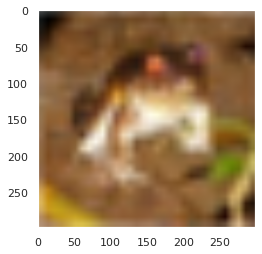

In [70]:
testimage = tf.image.resize(train_images[0,:,:,:],size=[299,299])

import matplotlib.pyplot
matplotlib.pyplot.rcParams["axes.grid"] = False  #  Remove the grid lines from the image.
matplotlib.pyplot.imshow(testimage)

In [71]:
import pickle
last_TDI_question_file = open('latent_vec.pk', 'wb')

In [72]:
latent_vec=[]

for i in range(0,50000,100):
    print(i)
    testimage= tf.image.resize(train_images[i:i+100,:,:,:],size=[299,299])
    latent_vec.append(inception(testimage))

latent_vec = tf.concat(latent_vec, axis=0)

pickle.dump(latent_vec, last_TDI_question_file)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18400
18

In [73]:
last_TDI_question_file2 = open('validation_latent.pk', 'wb')

In [74]:
validation_latent=[]

for i in range(0,10000,100):
    print(i)
    testimage= tf.image.resize(validation_images[i:i+100,:,:,:],size=[299,299])
    validation_latent.append(inception(testimage))

validation_latent = tf.concat(validation_latent, axis=0)

pickle.dump(validation_latent, last_TDI_question_file2)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900


In [75]:
model4 = keras.models.Sequential()

model4.add(
    keras.layers.Dense(
        hidden_size,
        activation='relu',
        use_bias=True,  # The default
        kernel_initializer=keras.initializers.TruncatedNormal(stddev=2048**-0.5)
    )
)

model4.add(
    keras.layers.Dense(
        10,
        activation='softmax',
        use_bias=True,  # The default
    )
)

In [76]:
model4.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.SGD(lr=0.01),
              metrics=['accuracy'])

In [78]:
history4 = model4.fit(latent_vec, y_train_hot,
                    epochs=25,
                    batch_size=300)

Epoch 1/25
167/167 [==============================] - 3s 19ms/step - loss: 1.2726 - accuracy: 0.6641
Epoch 2/25
167/167 [==============================] - 3s 19ms/step - loss: 0.7430 - accuracy: 0.7745
Epoch 3/25
167/167 [==============================] - 3s 19ms/step - loss: 0.6443 - accuracy: 0.7913
Epoch 4/25
167/167 [==============================] - 3s 20ms/step - loss: 0.5969 - accuracy: 0.8028
Epoch 5/25
167/167 [==============================] - 3s 19ms/step - loss: 0.5675 - accuracy: 0.8109
Epoch 6/25
167/167 [==============================] - 3s 19ms/step - loss: 0.5462 - accuracy: 0.8174
Epoch 7/25
167/167 [==============================] - 3s 20ms/step - loss: 0.5292 - accuracy: 0.8231
Epoch 8/25
167/167 [==============================] - 3s 19ms/step - loss: 0.5152 - accuracy: 0.8261
Epoch 9/25
167/167 [==============================] - 3s 19ms/step - loss: 0.5039 - accuracy: 0.8294
Epoch 10/25
167/167 [==============================] - 3s 19ms/step - loss: 0.4936 - accura

In [80]:
predicted_classes = np.argmax(model4.predict(validation_latent),axis=1)